In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
 
from datetime import datetime,timedelta
import datetime as dt
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# DATA Collection

urls = ['https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2010.csv','https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2011.csv',
        'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2012.csv','https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2013.csv',
        'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2014.csv','https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2015.csv',
        'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2016.csv','https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2017.csv',
        'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2018.csv','https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2019.csv',
        'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2020.csv','https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2021.csv']

dfs = [pd.read_csv(url,sep=';') for url in urls]
data = pd.concat(dfs, ignore_index=True)

data.drop(['WPts','LPts','W1','L1','W2','L2','W3','L3','W4','L4','W5','L5','Wsets','Lsets','EXW','EXL','LBW','LBL','SJW','SJL','MaxW','MaxL','AvgW','AvgL'],axis=1,inplace=True)
data.PSW= (data.PSW.replace(',','.', regex=True).astype(float))
data.PSL= (data.PSL.replace(',','.', regex=True).astype(float))
data.B365W= (data.B365W.replace(',','.', regex=True).astype(float))
data.B365L= (data.B365L.replace(',','.', regex=True).astype(float)) 

data['Date'] = pd.to_datetime(data.Date,dayfirst=True)

data.sort_values(['Date'], inplace=True)
data=data.reset_index(drop=True)


## **Data Pre-processing**

#### Timeframe selection

In [3]:
beg=datetime(2015,1,1) 
end=datetime(2021,12,31)

indices=data[(data.Date>beg)&(data.Date<=end)].index
data=data.iloc[indices,:]

data.sort_values(['Date'], inplace=True)
data=data.reset_index(drop=True)


#### ELO Ranking Computing

In [4]:
def compute_elo_rankings(data):
    """
    Given the list of matches in chronological order, for each match, computes 
    the elo ranking of the 2 players at the beginning of the match
    
    """
    print("Elo rankings computing...")
    players=list(pd.Series(list(data.Winner)+list(data.Loser)).value_counts().index) # Gather all players from data
    elo=pd.Series(np.ones(len(players))*1500,index=players) # Attribute Elo Ranking of 1500 to each player
    ranking_elo=[(1500,1500)]
    for i in range(1,len(data)):
        w=data.iloc[i-1,:].Winner   # Select Winner and Loser of the previous game
        l=data.iloc[i-1,:].Loser
        elow=elo[w]  
        elol=elo[l]
        pwin=1 / (1 + 10 ** ((elol - elow) / 400))  # Win prob resulting from elo. Ex: elol = 1900, elow = 2000. Delta = 100 -> winner prob = 64%
        K_win=32
        K_los=32
        new_elow=elow+K_win*(1-pwin) # The winner has his elo increased by K_win*(1-pwin). Ex: 1500 + 32*(1-0.64) = 1511.52. 
        new_elol=elol-K_los*(1-pwin) # A victory against a better ranked player grants more points.
        elo[w]=new_elow
        elo[l]=new_elol
        ranking_elo.append((elo[data.iloc[i,:].Winner],elo[data.iloc[i,:].Loser])) 
        if i%3000==0:
            print(str(i)+" matches computed...")
    ranking_elo=pd.DataFrame(ranking_elo,columns=["elo_winner","elo_loser"]) 
    ranking_elo["p_elo_winner"]=1 / (1 + 10 ** ((ranking_elo["elo_loser"] - ranking_elo["elo_winner"]) / 400))   
    ranking_elo["p_elo_loser"]=1 / (1 + 10 ** ((ranking_elo["elo_winner"] - ranking_elo["elo_loser"]) / 400))
    return ranking_elo

# Computing of the elo ranking of each player at the beginning of each match.
elo_rankings = compute_elo_rankings(data)
data = pd.concat([data,elo_rankings],1)


Elo rankings computing...
3000 matches computed...
6000 matches computed...
9000 matches computed...
12000 matches computed...
15000 matches computed...


#### Remove outliers and absurd values

In [5]:
data = data[data.Comment == 'Completed']
data.drop('Comment',axis=1,inplace=True)
data = data[data.Round != 'Round Robin']
data = data[(data.PSW >1)&(data.PSL>1)&(data.B365W>1)&(data.B365W>1)]
data = data[(data.WRank != 0) & (data.LRank != 0)]
data.dropna(axis=0,inplace=True)


#### Create cumulative stats 



In [6]:
data.reset_index(inplace=True)

df1 = data.copy()
df1['w']=1
df1['l']=0

index=df1['index']
winner=df1['Winner']
loser=df1['Loser']
surface=df1['Surface']
w=df1['w']
l=df1['l']
date=df1['Date']

df2 = pd.concat([index,winner,loser,surface,w,l,date], axis = 1)

player=pd.concat([winner,loser], axis = 0)
status=pd.concat([w,l], axis = 0)
index=pd.concat([index,index], axis = 0)
surface=pd.concat([surface,surface], axis = 0)
date=pd.concat([date,date], axis = 0)

df3 = pd.concat([index,player, status,surface,date], axis = 1)
df3.columns = ['index','Player','Winner','Surface','Date']

df_players = pd.pivot_table(df3,index=['Player','index','Surface','Date'])
df_players['Loser']=df_players['Winner'].apply(lambda x: 0 if x ==1 else 1)

df_players.reset_index(inplace=True)
df_players.set_index(['Date'], inplace=True)
df_players.sort_values(['Date'], inplace=True)

df_surface = df_players.copy()

df_players['Wins_R']=df_players.groupby('Player')['Winner'].transform(lambda x: x.rolling('3000D').sum()).fillna(0)-df_players['Winner']  # NB days can be changed if needed
df_players['Defeats_R']=df_players.groupby('Player')['Loser'].transform(lambda x: x.rolling('3000D').sum()).fillna(0)-df_players['Loser'] # NB days can be changed if needed
df_players['Played_R']=df_players['Wins_R']+df_players['Defeats_R']
df_players['WinRate_R']=df_players['Wins_R']/df_players['Played_R']
df_players['WinRate_R'].fillna(0,inplace=True)

df_surface['Wins_R']=df_surface.groupby(['Player','Surface'])['Winner'].transform(lambda x: x.rolling('3000D').sum()).fillna(0)-df_surface['Winner']  # NB days can be changed if needed
df_surface['Defeats_R']=df_surface.groupby(['Player','Surface'])['Loser'].transform(lambda x: x.rolling('3000D').sum()).fillna(0)-df_surface['Loser'] # NB days can be changed if needed
df_surface['Played_R']=df_surface['Wins_R']+df_surface['Defeats_R']
df_surface['WinRate_R']=df_surface['Wins_R']/df_surface['Played_R']
df_surface['WinRate_R'].fillna(0,inplace=True)

df_players.sort_values(['index','Loser'], inplace=True)
df_surface.sort_values(['index','Loser'], inplace=True)

Players_merge = pd.DataFrame({'Winner':df_players['Player'].iloc[::2].values, 'Loser':df_players['Player'].iloc[1::2].values,
                        'Winner_wins_R':df_players['Wins_R'].iloc[::2].values, 'Loser_wins_R':df_players['Wins_R'].iloc[1::2].values,
                        'Winner_defeats_R':df_players['Defeats_R'].iloc[::2].values, 'Loser_defeats_R':df_players['Defeats_R'].iloc[1::2].values,
                        'Winner_Played_R':df_players['Played_R'].iloc[::2].values, 'Loser_Played_R':df_players['Played_R'].iloc[1::2].values,
                        'Winner_WinRate_R':df_players['WinRate_R'].iloc[::2].values, 'Loser_WinRate_R':df_players['WinRate_R'].iloc[1::2].values,
                        'Winner_wins_S':df_surface['Wins_R'].iloc[::2].values, 'Loser_wins_S':df_surface['Wins_R'].iloc[1::2].values,
                        'Winner_defeats_S':df_surface['Defeats_R'].iloc[::2].values, 'Loser_defeats_S':df_surface['Defeats_R'].iloc[1::2].values,
                        'Winner_Played_S':df_surface['Played_R'].iloc[::2].values, 'Loser_Played_S':df_surface['Played_R'].iloc[1::2].values,
                        'Winner_WinRate_S':df_surface['WinRate_R'].iloc[::2].values, 'Loser_WinRate_S':df_surface['WinRate_R'].iloc[1::2].values,
                        'index':df_players['index'].iloc[1::2].values})

Players_merge.rename(columns={'index': 'index_t', 'Winner': 'Winner_t', 'Loser': 'Loser_t'},inplace=True)
data=pd.concat([data,Players_merge], axis = 1)
data.drop(['index_t','Winner_t','Loser_t'],axis=1,inplace=True)

#### Remove Winners / Losers -> Replace with P1 and P2 taken randomly 

In [7]:

v = data[['Winner', 'Loser']].values
ix = np.random.randint(0,v.shape[1],data.shape[0])
data['P1'] = np.take_along_axis(v, ix[:,None], 1)

data['P2'] = np.where(data.P1 == data.Winner,data.Loser, data.Winner)

data['P1_Rank']=np.where(data.P1 == data.Winner,data.WRank,data.LRank)
data['P2_Rank']=np.where(data.P2 == data.Winner,data.WRank,data.LRank)

data['P1_Elo']=np.where(data.P1 == data.Winner,data.elo_winner,data.elo_loser)
data['P2_Elo']=np.where(data.P2 == data.Winner,data.elo_winner,data.elo_loser)

data['P1_p_Elo']=np.where(data.P1 == data.Winner,data.p_elo_winner,data.p_elo_loser)
data['P2_p_Elo']=np.where(data.P2 == data.Winner,data.p_elo_winner,data.p_elo_loser)

data['P1_Odds_Pin']=np.where(data.P1 == data.Winner,data.PSW,data.PSL)
data['P2_Odds_Pin']=np.where(data.P2 == data.Winner,data.PSW,data.PSL)

data['P1_Odds_B365']=np.where(data.P1 == data.Winner,data.B365W,data.B365L)
data['P2_Odds_B365']=np.where(data.P2 == data.Winner,data.B365W,data.B365L)

data['P1_Wins']=np.where(data.P1 == data.Winner,data.Winner_wins_R,data.Loser_wins_R)
data['P2_Wins']=np.where(data.P2 == data.Winner,data.Winner_wins_R,data.Loser_wins_R)

data['P1_Defeats']=np.where(data.P1 == data.Winner,data.Winner_defeats_R,data.Loser_defeats_R)
data['P2_Defeats']=np.where(data.P2 == data.Winner,data.Winner_defeats_R,data.Loser_defeats_R)

data['P1_Played']=np.where(data.P1 == data.Winner,data.Winner_Played_R,data.Loser_Played_R)
data['P2_Played']=np.where(data.P2 == data.Winner,data.Winner_Played_R,data.Loser_Played_R)

data['P1_WinRate']=np.where(data.P1 == data.Winner,data.Winner_WinRate_R,data.Loser_WinRate_R)
data['P2_WinRate']=np.where(data.P2 == data.Winner,data.Winner_WinRate_R,data.Loser_WinRate_R)

data['P1_Surface_Wins']=np.where(data.P1 == data.Winner,data.Winner_wins_S,data.Loser_wins_S)
data['P2_Surface_Wins']=np.where(data.P2 == data.Winner,data.Winner_wins_S,data.Loser_wins_S)

data['P1_Surface_Defeats']=np.where(data.P1 == data.Winner,data.Winner_defeats_S,data.Loser_defeats_S)
data['P2_Surface_Defeats']=np.where(data.P2 == data.Winner,data.Winner_defeats_S,data.Loser_defeats_S)

data['P1_Surface_Played']=np.where(data.P1 == data.Winner,data.Winner_Played_S,data.Loser_Played_S)
data['P2_Surface_Played']=np.where(data.P2 == data.Winner,data.Winner_Played_S,data.Loser_Played_S)

data['P1_Surface_WinRate']=np.where(data.P1 == data.Winner,data.Winner_WinRate_S,data.Loser_WinRate_S)
data['P2_Surface_WinRate']=np.where(data.P2 == data.Winner,data.Winner_WinRate_S,data.Loser_WinRate_S)


#### Target variable preparation

In [8]:
data['Won']=np.where(data.P1 == data.Winner,1,2)
 
data.drop(['WRank','LRank','PSL','PSW','B365W','B365L','elo_winner','elo_loser','p_elo_winner','p_elo_loser','Loser','Winner',
           'Winner_wins_R','Loser_wins_R','Winner_defeats_R','Loser_defeats_R','Winner_Played_R','Loser_Played_R','Winner_WinRate_R','Loser_WinRate_R',
           'Winner_wins_S','Loser_wins_S','Winner_defeats_S','Loser_defeats_S','Winner_Played_S','Loser_Played_S','Winner_WinRate_S','Loser_WinRate_S'],axis=1,inplace=True)

In [9]:
cols = list(data.columns.values) # Make a list of all of the columns in the df
cols.pop(cols.index('Won')) # Remove 'Winner' from list
data = data[cols+['Won']] # change dataframe with Winner at the end

pd.set_option('max_colwidth', 13)

In [10]:
data['Year']=data.Date.dt.year
data['Month']=data.Date.dt.month

In [11]:
data_4_ROI=data.copy()
data_4_ROI.tail()

,index,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,P1,P2,P1_Rank,P2_Rank,P1_Elo,P2_Elo,P1_p_Elo,P2_p_Elo,P1_Odds_Pin,P2_Odds_Pin,P1_Odds_B365,P2_Odds_B365,P1_Wins,P2_Wins,P1_Defeats,P2_Defeats,P1_Played,P2_Played,P1_WinRate,P2_WinRate,P1_Surface_Wins,P2_Surface_Wins,P1_Surface_Defeats,P2_Surface_Defeats,P1_Surface_Played,P2_Surface_Played,P1_Surface_WinRate,P2_Surface_WinRate,Won,Year,Month
15701,16475,49,New York,US Open,2021-09-08,Grand Slam,Outdoor,Hard,Quarterfi...,5,Harris L.,Zverev A.,46.0,4.0,1703.441883,1967.301571,0.179624,0.820376,6.90,1.14,6.00,1.12,41,259,40,112,81,371,0.506173,0.698113,33,147,28,66,61,213,0.540984,0.690141,2,2021,9
15702,16476,49,New York,US Open,2021-09-09,Grand Slam,Outdoor,Hard,Quarterfi...,5,Berrettin...,Djokovic N.,8.0,1.0,1909.649603,2128.466902,0.221040,0.778960,7.81,1.12,7.00,1.10,103,331,54,45,157,376,0.656051,0.880319,39,193,30,24,69,217,0.565217,0.889401,2,2021,9
15703,16477,49,New York,US Open,2021-09-10,Grand Slam,Outdoor,Hard,Semifinals,5,Medvedev D.,Auger-Ali...,2.0,15.0,1974.037478,1803.902012,0.726985,0.273015,1.17,5.95,1.16,5.00,181,87,84,63,265,150,0.683019,0.580000,141,52,51,37,192,89,0.734375,0.584270,1,2021,9
15704,16478,49,New York,US Open,2021-09-11,Grand Slam,Outdoor,Hard,Semifinals,5,Zverev A.,Djokovic N.,4.0,1.0,1973.049533,2135.540195,0.281836,0.718164,3.14,1.42,3.00,1.40,260,332,112,45,372,377,0.698925,0.880637,148,194,66,24,214,218,0.691589,0.889908,2,2021,9
15705,16479,49,New York,US Open,2021-09-12,Grand Slam,Outdoor,Hard,The Final,5,Medvedev D.,Djokovic N.,2.0,1.0,1982.773962,2144.558955,0.282659,0.717341,3.14,1.42,3.00,1.40,182,333,84,45,266,378,0.684211,0.880952,142,195,51,24,193,219,0.735751,0.890411,1,2021,9


**SCENARIO 1 : BET ON HIGHEST ODDS ONLY**

In [12]:
# Features selection

data1=data[['Year','Month','P1_Odds_Pin','P2_Odds_Pin','Won']].copy()

# We bet on higher odds

data1['Bets_P1']=np.where(data1['P1_Odds_Pin'] >data1 ['P2_Odds_Pin'],1,0)
data1['Bets_P2']=np.where(data1['P2_Odds_Pin'] >data1 ['P1_Odds_Pin'],2,0)

# Counter of bets and bets won

data1['Bets']=np.where((data1['Bets_P1'] == 1)|(data1['Bets_P2'] == 2),1,0)
data1['Wins']=np.where((data1['Bets_P1'] == data1['Won'])|(data1['Bets_P2']== data1['Won']),1,0)
                           
# Profit

data1['P1_$']=np.where((data1['Bets_P1'] == data1['Won']),data1['P1_Odds_Pin'],0)
data1['P2_$']=np.where((data1['Bets_P2'] == data1['Won']),data1['P2_Odds_Pin'],0)  
data1['Net_Profit']=data1['P1_$']+data1['P2_$']-data1['Bets']

In [13]:
data1.head()

,Year,Month,P1_Odds_Pin,P2_Odds_Pin,Won,Bets_P1,Bets_P2,Bets,Wins,P1_$,P2_$,Net_Profit
0,2015,1,2.65,1.53,2,1,0,1,0,0.0,0.00,-1.00
1,2015,1,3.50,1.34,2,1,0,1,0,0.0,0.00,-1.00
2,2015,1,1.65,2.37,1,0,2,1,0,0.0,0.00,-1.00
3,2015,1,1.23,4.67,2,0,2,1,1,0.0,4.67,3.67
4,2015,1,2.10,1.81,2,1,0,1,0,0.0,0.00,-1.00


Overall Profit: -876.14 

ROI: -5.6% 



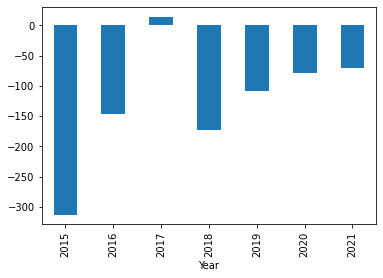

In [14]:
# Let's now plot the ROI

Pyear1= data1.groupby(by='Year').Net_Profit.sum()
print('Overall Profit:',"%.2f" % Pyear1.sum(),'\n')
print('ROI:',"{0:.1%}".format(Pyear1.sum()/data1['Bets'].sum()),'\n')

Pyear1.plot.bar();

**SCENARIO 2 : BET ON ALL GAMES BASED ON OUR BEST PREDICTIONS**

In [15]:
# Features selection

data2=data[['Year','Month','P1_Surface_WinRate','P2_Surface_WinRate','P1_p_Elo','P2_p_Elo','P1_Rank','P2_Rank','P1_Odds_Pin','P2_Odds_Pin','Won']].copy()


In [16]:
# Data split, normalization, preparation of predictions dataframe

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer

DATA = data2.drop('Won',axis=1)
TARGET = data2['Won']

X_train,X_test,y_train,y_test=train_test_split(DATA,TARGET,test_size=0.2,random_state=10)

df1 = X_test.copy()  
df1 =pd.concat([df1,y_test], axis = 1) # Preparation of the dataframe that combines : data + odds + predictions + results

df1.drop(['P1_Surface_WinRate','P2_Surface_WinRate','P1_p_Elo','P2_p_Elo','P1_Rank','P2_Rank'],axis=1,inplace=True) # we do not need the features in our prediction dataframe

X_train.drop(['P1_Odds_Pin','P2_Odds_Pin','Year','Month'],axis=1,inplace=True) # We don't want to use bookmaker odds to train our model
X_test.drop(['P1_Odds_Pin','P2_Odds_Pin','Year','Month'],axis=1,inplace=True)

from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(random_state=0)
scaler=qt.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test = scaler.transform(X_test)


As explained in the previous notebook, we chose the Logistic Regression as the preferred method: combination of high accuracy and fast execution

In [17]:
from sklearn import linear_model

# Model training

clf=linear_model.LogisticRegression(random_state=10)
clf.fit(X_train_scaled,y_train)

# Model assessment

y_pred = clf.predict(X_test)

# Confusion Matrix 

cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)

# Score

print('\n''Score:',"%.2f" % clf.score(X_test, y_test))

#Classification report

print('\n',classification_report(y_test, y_pred))


Classe prédite     1     2
Classe réelle             
1               1028   540
2                512  1062

Score: 0.67

               precision    recall  f1-score   support

           1       0.67      0.66      0.66      1568
           2       0.66      0.67      0.67      1574

    accuracy                           0.67      3142
   macro avg       0.67      0.67      0.67      3142
weighted avg       0.67      0.67      0.67      3142



In [18]:
# Gathering elements for predictions template

preds=pd.DataFrame(clf.predict_proba(X_test))

preds.reset_index(inplace=True)
df1.reset_index(inplace=True)
preds.drop('index',axis=1,inplace=True)
df1.drop('index',axis=1,inplace=True)

df1=pd.concat([df1,preds], axis = 1)
df1.rename(columns={0: "P1_prob", 1: "P2_prob"},inplace=True)

df1.head()

,Year,Month,P1_Odds_Pin,P2_Odds_Pin,Won,P1_prob,P2_prob
0,2015,2,3.21,1.41,2,0.380297,0.619703
1,2020,9,1.59,2.52,2,0.740710,0.259290
2,2017,6,4.69,1.23,1,0.271282,0.728718
3,2017,6,1.23,4.77,1,0.663941,0.336059
4,2021,4,3.22,1.40,2,0.325226,0.674774


In [19]:
# We bet on the higher probability win according to our prediction

df1['Bets_P1']=np.where(df1['P1_prob'] >df1 ['P2_prob'],1,0)
df1['Bets_P2']=np.where(df1['P2_prob'] >df1 ['P1_prob'],2,0)

# Counter of bets and bets won

df1['Bets']=np.where((df1['Bets_P1'] == 1)|(df1['Bets_P2'] == 2),1,0)
df1['Wins']=np.where((df1['Bets_P1'] == df1['Won'])|(df1['Bets_P2']== df1['Won']),1,0)
                           
# Profit

df1['P1_$']=np.where((df1['Bets_P1'] == df1['Won']),df1['P1_Odds_Pin'],0)
df1['P2_$']=np.where((df1['Bets_P2'] == df1['Won']),df1['P2_Odds_Pin'],0)  
df1['Net_Profit']=df1['P1_$']+df1['P2_$']-df1['Bets']

In [20]:
df1.head()

,Year,Month,P1_Odds_Pin,P2_Odds_Pin,Won,P1_prob,P2_prob,Bets_P1,Bets_P2,Bets,Wins,P1_$,P2_$,Net_Profit
0,2015,2,3.21,1.41,2,0.380297,0.619703,0,2,1,1,0.00,1.41,0.41
1,2020,9,1.59,2.52,2,0.740710,0.259290,1,0,1,0,0.00,0.00,-1.00
2,2017,6,4.69,1.23,1,0.271282,0.728718,0,2,1,0,0.00,0.00,-1.00
3,2017,6,1.23,4.77,1,0.663941,0.336059,1,0,1,1,1.23,0.00,0.23
4,2021,4,3.22,1.40,2,0.325226,0.674774,0,2,1,1,0.00,1.40,0.40


Overall Profit: -70.36 

ROI: -2.2% 



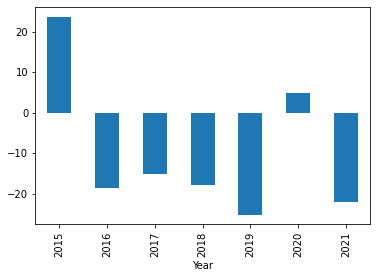

In [21]:
# Let's now plot the ROI

Pyear2= df1.groupby(by='Year').Net_Profit.sum()
print('Overall Profit:',"%.2f" % Pyear2.sum(),'\n')
print('ROI:',"{0:.1%}".format(Pyear2.sum()/df1['Bets'].sum()),'\n')

Pyear2.plot.bar();

ROI is better than in Scenario 1 but remains negative

**SCENARIO 3 : BUILD A DECISION THRESHOLD BASED ON THE COMPARISON BETWEEN OUR PREDICTIONS AND THE BOOKMAKER ONES**

The main drive when building a model is to make it as efficient and close to the truth as possible without overfitting too much. What if we were not looking for the best model but just an 'ok' one and instead focus on the 'kind' of variables we want to feed it with?

Predicting the victory of a player over the other is done by using a combination of variables, some of which could be thought as 'static' (like the rank of the player) when others are more dynamic (recent wins, injuries, etc).

Most of the time, those features converge but in other circumstances they may diverge -> We will try to build on that idea in order to build an efficient ROI forecast.


So the first thing we want to do is to build a very simple model that will only focus on 'Static features' and we will use the ATP rank to do so. NB: There is a possibility that a slightly different or more complex one works as well but we won't focus on that research specifically in this notebook.

In [22]:
# Features selection

data3=data[['Year','Month','P1_Rank','P2_Rank','P1_Odds_Pin','P2_Odds_Pin','Won']].copy()


In [23]:
# Data split, normalization, preparation of predictions dataframe

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer

DATA = data3.drop('Won',axis=1)
TARGET = data3['Won']

# This time we separate the train and test set by chronological order.
# We will only select a small portion of the dataset to place our bets so it is preferable to keep a continous timeline to assess our predictions.
# Otherwise, given the small number of bets, the variance may be very high from one test set to another.

X_train=DATA[:10000]
y_train=TARGET[:10000]
X_test=DATA[10000:]
y_test=TARGET[10000:]


df2 = X_test.copy()  
df2 =pd.concat([df2,y_test], axis = 1) # Preparation of the dataframe that combines : data + odds + predictions + results

df2.drop(['P1_Rank','P2_Rank'],axis=1,inplace=True) # we do not need the features in our prediction dataframe

X_train.drop(['P1_Odds_Pin','P2_Odds_Pin','Year','Month'],axis=1,inplace=True) # We don't want to use bookmaker odds to train our model
X_test.drop(['P1_Odds_Pin','P2_Odds_Pin','Year','Month'],axis=1,inplace=True)

from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(random_state=0)
scaler=qt.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
from sklearn import linear_model

# Model training

clf=linear_model.LogisticRegression(random_state=10)
clf.fit(X_train_scaled,y_train)

# Model assessment

y_pred = clf.predict(X_test)

# Confusion Matrix 

cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)

# Score

print('\n''Score:',"%.2f" % clf.score(X_test, y_test))

#Classification report

print('\n',classification_report(y_test, y_pred))

Classe prédite     1     2
Classe réelle             
1               1683  1135
2               1017  1871

Score: 0.62

               precision    recall  f1-score   support

           1       0.62      0.60      0.61      2818
           2       0.62      0.65      0.63      2888

    accuracy                           0.62      5706
   macro avg       0.62      0.62      0.62      5706
weighted avg       0.62      0.62      0.62      5706



In [25]:
# Gathering elements for predictions template

preds=pd.DataFrame(clf.predict_proba(X_test))

preds.reset_index(inplace=True)
df2.reset_index(inplace=True)
preds.drop('index',axis=1,inplace=True)
df2.drop('index',axis=1,inplace=True)

df2=pd.concat([df2,preds], axis = 1)
df2.rename(columns={0: "P1_prob", 1: "P2_prob"},inplace=True)

df2.head()

,Year,Month,P1_Odds_Pin,P2_Odds_Pin,Won,P1_prob,P2_prob
0,2018,10,1.87,2.04,1,0.525461,0.474539
1,2018,10,1.51,2.75,1,0.628763,0.371237
2,2018,11,2.11,1.83,2,0.476010,0.523990
3,2018,11,3.29,1.40,2,0.345191,0.654809
4,2018,11,1.29,4.05,1,0.582468,0.417532


At this stage we want to build a decision threshold that will test our predictions based on 'static' features against the bookmaker predictions that include both 'static' and 'dynamic' features.


Despite it includes some other factors like the bookmaker profit and some bias linked to the number of bets on the player, we find the formula: '(1/odds)' is a correct approximate of the bookmaker expected player winrate. At least sufficiently good for the purpose of our comparison. So we compute those new columns.

In [26]:
# Decision Threshold computing

df2['P1_Proba_Pin']=1/df2['P1_Odds_Pin']
df2['P2_Proba_Pin']=1/df2['P2_Odds_Pin']
df2['P1_DT']=df2['P1_prob']/df2['P1_Proba_Pin']
df2['P2_DT']=df2['P2_prob']/df2['P2_Proba_Pin']

df2.head()

,Year,Month,P1_Odds_Pin,P2_Odds_Pin,Won,P1_prob,P2_prob,P1_Proba_Pin,P2_Proba_Pin,P1_DT,P2_DT
0,2018,10,1.87,2.04,1,0.525461,0.474539,0.534759,0.490196,0.982611,0.968060
1,2018,10,1.51,2.75,1,0.628763,0.371237,0.662252,0.363636,0.949433,1.020901
2,2018,11,2.11,1.83,2,0.476010,0.523990,0.473934,0.546448,1.004381,0.958901
3,2018,11,3.29,1.40,2,0.345191,0.654809,0.303951,0.714286,1.135679,0.916732
4,2018,11,1.29,4.05,1,0.582468,0.417532,0.775194,0.246914,0.751383,1.691006


From there we want to find the right interval where the expected ROI will be positive and stable enough.


In [27]:
profit=0
profit_vector=[]
threshold=[]
Nb_match=[]
df2['Bets']=0

for i in np.arange(0.4,1,0.1): # threshold loop

  for k in range(df2.shape[0]): # dataset lines loop

    if (df2.iloc[k,9] <i) & (df2.iloc[k,2] >1.2) & (df2.iloc[k,2] <5) & (np.abs(df2.iloc[k,2]-df2.iloc[k,3])>1):
      df2.iloc[k,11] = 1 # If all 3 conditions are met --> bet on P1

    elif (df2.iloc[k,10] <i) & (df2.iloc[k,3] >1.2) & (df2.iloc[k,3] <5) & (np.abs(df2.iloc[k,2]-df2.iloc[k,3])>1):
      df2.iloc[k,11] = 2 # If all 3 conditions are met --> bet on P2

    else:
      df2.iloc[k,11] = 0 # No bets

  ROI = df2[(df2['Bets'] ==1)|(df2['Bets'] ==2)] # new datasets limited to the games we bet on
  ROI['profit']=0

  for k in range(ROI.shape[0]): # dataset lines loop
    if (ROI.iloc[k,4]==ROI.iloc[k,11]) & (ROI.iloc[k,11] == 1): # if bet on player 1 is won
      ROI.iloc[k,12]=ROI.iloc[k,2] # profit = P1 odd
    elif (ROI.iloc[k,4]==ROI.iloc[k,11]) & (ROI.iloc[k,11] == 2): # if bet on player 2 is won
      ROI.iloc[k,12]=ROI.iloc[k,3] # profit = P2 odd
    else:
      ROI.iloc[k,12]= 0 

    profit+=ROI.iloc[k,12]-1
    
  profit_vector.append(profit)
  threshold.append(i)
  Nb_match.append(ROI.shape[0])
  profit=0


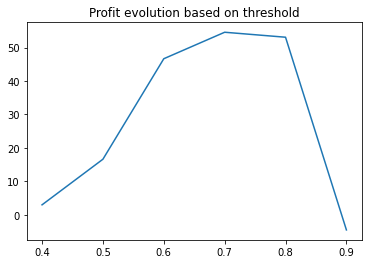

In [28]:
plt.plot(threshold,profit_vector)
plt.title('Profit evolution based on threshold');

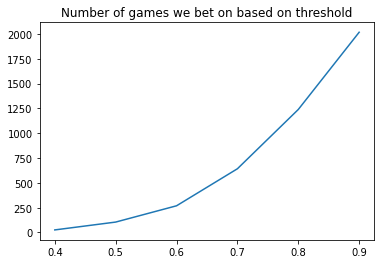

In [29]:
plt.plot(threshold,Nb_match)
plt.title('Number of games we bet on based on threshold');

In [30]:
df2['Bets_P1']=np.where((df2['P1_DT'] <0.7) & 
                           (df2['P1_Odds_Pin'] >1.2) & 
                           (df2['P1_Odds_Pin'] <5) &
                           (np.abs(df2['P1_Odds_Pin']-df2['P2_Odds_Pin'])>1),1,0)

df2['Bets_P2']=np.where((df2['P2_DT'] <0.7) & 
                           (df2['P2_Odds_Pin'] >1.2) & 
                           (df2['P2_Odds_Pin'] <5) &
                           (np.abs(df2['P1_Odds_Pin']-df2['P2_Odds_Pin'])>1),2,0)

In [31]:
# Counter of bets and bets won

df2['Bets']=np.where((df2['Bets_P1'] == 1)|(df2['Bets_P2'] == 2),1,0)
df2['Wins']=np.where((df2['Bets_P1'] == df2['Won'])|(df2['Bets_P2']== df2['Won']),1,0)
                           

In [32]:
# Profit

df2['P1_$']=np.where((df2['Bets_P1'] == df2['Won']),df2['P1_Odds_Pin'],0)
df2['P2_$']=np.where((df2['Bets_P2'] == df2['Won']),df2['P2_Odds_Pin'],0)  
df2['Net_Profit']=df2['P1_$']+df2['P2_$']-df2['Bets']

In [33]:
df2.head()

,Year,Month,P1_Odds_Pin,P2_Odds_Pin,Won,P1_prob,P2_prob,P1_Proba_Pin,P2_Proba_Pin,P1_DT,P2_DT,Bets,Bets_P1,Bets_P2,Wins,P1_$,P2_$,Net_Profit
0,2018,10,1.87,2.04,1,0.525461,0.474539,0.534759,0.490196,0.982611,0.968060,0,0,0,0,0.0,0.0,0.0
1,2018,10,1.51,2.75,1,0.628763,0.371237,0.662252,0.363636,0.949433,1.020901,0,0,0,0,0.0,0.0,0.0
2,2018,11,2.11,1.83,2,0.476010,0.523990,0.473934,0.546448,1.004381,0.958901,0,0,0,0,0.0,0.0,0.0
3,2018,11,3.29,1.40,2,0.345191,0.654809,0.303951,0.714286,1.135679,0.916732,0,0,0,0,0.0,0.0,0.0
4,2018,11,1.29,4.05,1,0.582468,0.417532,0.775194,0.246914,0.751383,1.691006,0,0,0,0,0.0,0.0,0.0


Overall Profit: 54.61 

ROI: 8.5% 



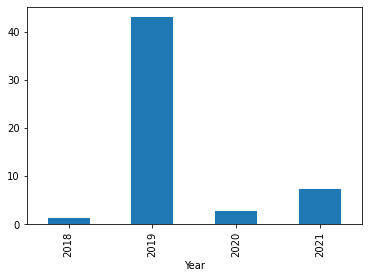

In [34]:
# Let's now plot the ROI

Pyear3= df2.groupby(by=['Year']).Net_Profit.sum()
print('Overall Profit:',"%.2f" % Pyear3.sum(),'\n')
print('ROI:',"{0:.1%}".format(Pyear3.sum()/df2['Bets'].sum()),'\n')

Pyear3.plot.bar();

With this approach, the ROI seems fairly stable across recent years.
We are still looking at other options and strategies to refine the strategy, one of them could be to place higher bets where our confidence is the highest.
